# Election

In [178]:
from sqlalchemy.orm import Session
from models import (
    ResultatElection, ElectionStats, Candidat, Departement, Election, PopulationDepartement, Entreprise, Menage
)
import pandas as pd
from db import SessionLocal

# Création de la session
session = SessionLocal()

# Requête pour récupérer tous les résultats avec relations
results = session.query(
    ResultatElection.id.label("resultat_id"),
    ResultatElection.nb_voix,
    ResultatElection.code_dept,
    Departement.nom_dept,
    ResultatElection.election_id,
    Election.date.label("date_election"),
    Election.type_election,
    Election.tour,
    Candidat.id.label("candidat_id"),
    Candidat.nom.label("nom_candidat"),
    Candidat.prenom.label("prenom_candidat"),
    Candidat.sexe,  # récupère l'Enum
).join(
    Candidat, ResultatElection.candidat_id == Candidat.id
).join(
    Departement, ResultatElection.code_dept == Departement.code_dept
).join(
    Election, ResultatElection.election_id == Election.id
).all()

# Conversion en DataFrame et transformation de l'Enum en string
import pandas as pd

df_resultats = pd.DataFrame([r._asdict() for r in results])
df_resultats["sexe_candidat"] = df_resultats["sexe"].apply(lambda x: x.value)  # -> "Masculin" ou "Féminin"
df_resultats.drop(columns=["sexe"], inplace=True)
df_resultats["type_election"] = df_resultats["type_election"].apply(lambda x: x.value)

# Supprimer les colonnes inutiles
df_resultats = df_resultats.drop(columns=["candidat_id", "resultat_id"])

df_resultats.head()



2026-01-18 12:44:13,979 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2026-01-18 12:44:14,009 INFO sqlalchemy.engine.Engine SELECT resultats_election.id AS resultat_id, resultats_election.nb_voix AS resultats_election_nb_voix, resultats_election.code_dept AS resultats_election_code_dept, departements.nom_dept AS departements_nom_dept, resultats_election.election_id AS resultats_election_election_id, elections.date AS date_election, elections.type_election AS elections_type_election, elections.tour AS elections_tour, candidats.id AS candidat_id, candidats.nom AS nom_candidat, candidats.prenom AS prenom_candidat, candidats.sexe AS candidats_sexe 
FROM resultats_election JOIN candidats ON resultats_election.candidat_id = candidats.id JOIN departements ON resultats_election.code_dept = departements.code_dept JOIN elections ON resultats_election.election_id = elections.id
2026-01-18 12:44:14,011 INFO sqlalchemy.engine.Engine [cached since 2.076e+04s ago] {}


,nb_voix,code_dept,nom_dept,election_id,date_election,type_election,tour,nom_candidat,prenom_candidat,sexe_candidat
0,7268,01,ain,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin
1,3455,02,aisne,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin
2,3232,03,allier,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin
3,2933,04,alpes-de-haute-provence,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin
4,3147,05,hautes-alpes,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin


In [179]:
# Dictionnaire de mapping nom_candidat -> parti
partis = {
    'JOLY': 'EELV',
    'LE PEN': 'RN',
    'SARKOZY': 'LR',
    'MÉLENCHON': 'LFI',
    'POUTOU': 'NPA',
    'ARTHAUD': 'LO',
    'CHEMINADE': 'SP',
    'BAYROU': 'MoDem',
    'DUPONT-AIGNAN': 'DF',
    'HOLLANDE': 'PS',
    'MACRON': 'LREM',
    'FILLON': 'LR',
    'HAMON': 'PS',
    'LASSALLE': 'Résistons !',
    'ASSELINEAU': 'UPR',
    'ROUSSEL': 'PCF',
    'ZEMMOUR': 'Reconquête',
    'HIDALGO': 'PS',
    'JADOT': 'EELV',
    'PÉCRESSE': 'LR'
}

# Création de la nouvelle colonne 'parti'
df_resultats['parti'] = df_resultats['nom_candidat'].map(partis)

# Vérification
print(df_resultats.head(1600))


      nb_voix code_dept                  nom_dept  election_id date_election  \
0        7268        01                       ain            1    2012-04-22   
1        3455        02                     aisne            1    2012-04-22   
2        3232        03                    allier            1    2012-04-22   
3        2933        04   alpes-de-haute-provence            1    2012-04-22   
4        3147        05              hautes-alpes            1    2012-04-22   
...       ...       ...                       ...          ...           ...   
1595    66292        ZD                la réunion            3    2017-04-23   
1596     6403        ZM                   mayotte            3    2017-04-23   
1597    11089        ZN        nouvelle-calédonie            3    2017-04-23   
1598    11128        ZP       polynésie française            3    2017-04-23   
1599      473        ZS  saint-pierre-et-miquelon            3    2017-04-23   

       type_election  tour nom_candidat

In [180]:
from models import ElectionStats

# Requête
stats = session.query(
    ElectionStats.election_id,
    ElectionStats.code_dept,
    ElectionStats.nb_inscrits,
    ElectionStats.nb_votants,
    ElectionStats.nb_abstentions,
    ElectionStats.nb_blancs_nuls
).all()

# Conversion en DataFrame
df_stats = pd.DataFrame([s._asdict() for s in stats])
df_stats.head()


2026-01-18 12:44:19,495 INFO sqlalchemy.engine.Engine SELECT election_stats.election_id AS election_stats_election_id, election_stats.code_dept AS election_stats_code_dept, election_stats.nb_inscrits AS election_stats_nb_inscrits, election_stats.nb_votants AS election_stats_nb_votants, election_stats.nb_abstentions AS election_stats_nb_abstentions, election_stats.nb_blancs_nuls AS election_stats_nb_blancs_nuls 
FROM election_stats
2026-01-18 12:44:19,497 INFO sqlalchemy.engine.Engine [cached since 2.043e+04s ago] {}


,election_id,code_dept,nb_inscrits,nb_votants,nb_abstentions,nb_blancs_nuls
0,1,01,393808,327812,65996,6453
1,1,02,376068,303140,72928,5196
2,1,03,256275,211009,45266,5059
3,1,04,123933,102899,21034,2111
4,1,05,106865,88619,18246,1842


In [181]:
df_resultats = df_resultats.merge(
    df_stats,
    on=["election_id", "code_dept"],
    how="left"
)


df_resultats.head()

,nb_voix,code_dept,nom_dept,election_id,date_election,type_election,tour,nom_candidat,prenom_candidat,sexe_candidat,parti,nb_inscrits,nb_votants,nb_abstentions,nb_blancs_nuls
0,7268,01,ain,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin,EELV,393808,327812,65996,6453
1,3455,02,aisne,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin,EELV,376068,303140,72928,5196
2,3232,03,allier,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin,EELV,256275,211009,45266,5059
3,2933,04,alpes-de-haute-provence,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin,EELV,123933,102899,21034,2111
4,3147,05,hautes-alpes,1,2012-04-22,Présidentielle,1,JOLY,EVA,Féminin,EELV,106865,88619,18246,1842


In [182]:
# Calcul du pourcentage de voix sur le nombre de votants
df_resultats['pct_voix'] = (df_resultats['nb_voix'] / df_resultats['nb_votants']) * 100

# Arrondi à 2 décimales si tu veux
df_resultats['pct_voix'] = df_resultats['pct_voix'].round(2)

# Vérification
print(df_resultats.head(1000))

     nb_voix code_dept                 nom_dept  election_id date_election  \
0       7268        01                      ain            1    2012-04-22   
1       3455        02                    aisne            1    2012-04-22   
2       3232        03                   allier            1    2012-04-22   
3       2933        04  alpes-de-haute-provence            1    2012-04-22   
4       3147        05             hautes-alpes            1    2012-04-22   
..       ...       ...                      ...          ...           ...   
995    38446        32                     gers            1    2012-04-22   
996   260043        33                  gironde            1    2012-04-22   
997   160931        34                  hérault            1    2012-04-22   
998   183935        35          ille-et-vilaine            1    2012-04-22   
999    41505        36                    indre            1    2012-04-22   

      type_election  tour nom_candidat prenom_candidat sexe_can

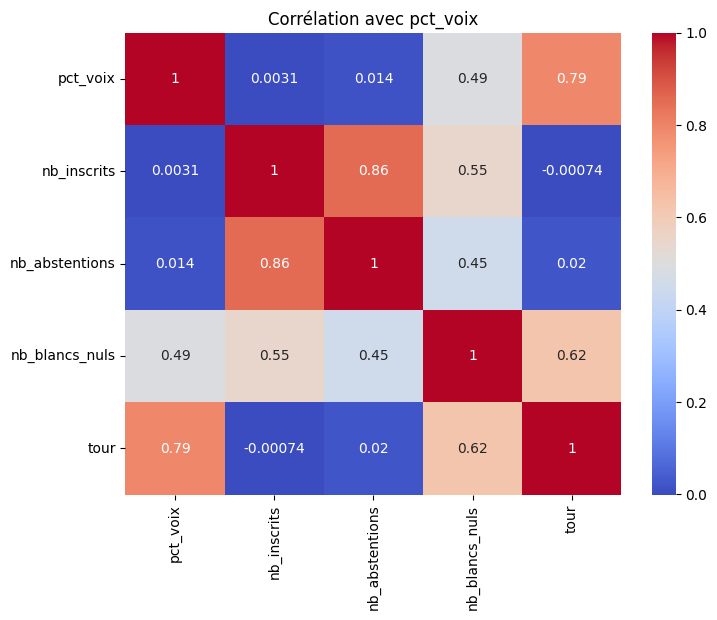

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = [
    'pct_voix',
    'nb_inscrits',
    'nb_abstentions',
    'nb_blancs_nuls',
    'tour'
]

corr = df_resultats[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Corrélation avec pct_voix")
plt.show()


In [184]:
features = [
    'nb_inscrits',
    'nb_abstentions',
    'nb_blancs_nuls',
    'tour'
]


In [185]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = df_resultats[features].dropna()

vif_df = pd.DataFrame()
vif_df['variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df.sort_values('VIF', ascending=False))


         variable        VIF
0     nb_inscrits  10.380959
1  nb_abstentions   7.996179
2  nb_blancs_nuls   3.124338
3            tour   2.962254


In [186]:
# S'assurer que la colonne est bien au format datetime
df_resultats['date_election'] = pd.to_datetime(df_resultats['date_election'])

# Extraire uniquement l'année
df_resultats['annee'] = df_resultats['date_election'].dt.year


In [187]:
import pandas as pd

# Fusionner prénom et nom en une seule colonne nom_candidat
df_resultats['nom_candidat'] = df_resultats['prenom_candidat'] + ' ' + df_resultats['nom_candidat']



In [188]:
df_resultats['pct_abstentions'] = df_resultats['nb_abstentions'] / df_resultats['nb_votants'] * 100
df_resultats['pct_blancs_nuls'] = df_resultats['nb_blancs_nuls'] / df_resultats['nb_votants'] * 100


In [189]:
colonnes_a_supprimer = [
    "nom_dept",
    "election_id",
    "prenom_candidat",
    "type_election",
    "sexe_candidat",
    'nb_votants',
    'nb_voix',
    'nb_inscrits',
    'date_election',
    'nb_abstentions',
    'nb_blancs_nuls'
]

df_resultats = df_resultats.drop(columns=colonnes_a_supprimer)


In [191]:
# Vérification
print(df_resultats.head(60))

   code_dept  tour nom_candidat parti  pct_voix  annee  pct_abstentions  \
0         01     1     EVA JOLY  EELV      2.22   2012        20.132271   
1         02     1     EVA JOLY  EELV      1.14   2012        24.057531   
2         03     1     EVA JOLY  EELV      1.53   2012        21.452166   
3         04     1     EVA JOLY  EELV      2.85   2012        20.441404   
4         05     1     EVA JOLY  EELV      3.55   2012        20.589264   
5         06     1     EVA JOLY  EELV      2.12   2012        25.913449   
6         07     1     EVA JOLY  EELV      2.74   2012        18.828952   
7         08     1     EVA JOLY  EELV      1.20   2012        25.954854   
8         09     1     EVA JOLY  EELV      2.80   2012        18.905056   
9         10     1     EVA JOLY  EELV      1.38   2012        22.902971   
10        11     1     EVA JOLY  EELV      2.05   2012        19.778651   
11        12     1     EVA JOLY  EELV      2.28   2012        17.232030   
12        13     1     EV

In [192]:
import pandas as pd

df_pivot = df_resultats.pivot_table(
    index=['code_dept', 'tour', 'annee', 'pct_abstentions', 'pct_blancs_nuls'],  # ce qui définit une ligne
    columns='parti',                        # une colonne par parti
    values='pct_voix',                      # la valeur à mettre dans les cellules
    fill_value=0                             # mettre 0 si un parti n’a pas de voix dans ce département
).reset_index()


In [193]:
df_resultats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4160 entries, 0 to 4159
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   code_dept        4160 non-null   object 
 1   tour             4160 non-null   int64  
 2   nom_candidat     4160 non-null   object 
 3   parti            4160 non-null   object 
 4   pct_voix         4160 non-null   float64
 5   annee            4160 non-null   int32  
 6   pct_abstentions  4160 non-null   float64
 7   pct_blancs_nuls  4160 non-null   float64
dtypes: float64(3), int32(1), int64(1), object(3)
memory usage: 243.9+ KB


In [196]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   code_dept        640 non-null    object 
 1   tour             640 non-null    int64  
 2   annee            640 non-null    int32  
 3   pct_abstentions  640 non-null    float64
 4   pct_blancs_nuls  640 non-null    float64
 5   DF               640 non-null    float64
 6   EELV             640 non-null    float64
 7   LFI              640 non-null    float64
 8   LO               640 non-null    float64
 9   LR               640 non-null    float64
 10  LREM             640 non-null    float64
 11  MoDem            640 non-null    float64
 12  NPA              640 non-null    float64
 13  PCF              640 non-null    float64
 14  PS               640 non-null    float64
 15  RN               640 non-null    float64
 16  Reconquête       640 non-null    float64
 17  Résistons !     

# PopulationDepartement

In [201]:
# Fusion avec PopulationDepartement
df_pop = pd.read_sql(session.query(PopulationDepartement).statement, session.bind)

2026-01-18 13:37:24,913 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2026-01-18 13:37:24,929 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2026-01-18 13:37:24,935 INFO sqlalchemy.engine.Engine [cached since 2.251e+04s ago] {'table_name': <sqlalchemy.sql.selectable.Select object at 0xffff3ec9fa90>, 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2026-01-18 13:37:24,975 INFO sqlalchemy.engine.Engine SELECT population_departement.id, population_departement.departement_code, population_departement.sexe_id, population_depa

In [202]:
df_pop = df_pop.rename(columns={
    "departement_code": "code_dept"
})
df_pop.head(10)


,id,code_dept,sexe_id,tranche_age_id,annee,population
0,1,ZA,2,1,2007,63118
1,2,ZA,2,2,2007,44730
2,3,ZA,2,3,2007,51025
3,4,ZA,2,4,2007,20686
4,5,ZA,2,5,2007,8766
5,6,ZB,2,1,2007,57391
6,7,ZB,2,2,2007,44191
7,8,ZB,2,3,2007,51680
8,9,ZB,2,4,2007,22116
9,10,ZB,2,5,2007,9592


In [ ]:
df_pop.info()

### Agrégation

In [203]:
# Population totale par département / année
pop_total = (
    df_pop
    .groupby(['code_dept', 'annee'])['population']
    .sum()
    .reset_index(name='population_totale')
)


In [204]:
print(pop_total.head(10))

  code_dept  annee  population_totale
0        01   2007             574377
1        01   2008             581355
2        01   2009             588853
3        01   2010             597341
4        01   2011             603827
5        01   2012             612191
6        01   2013             619497
7        01   2014             626127
8        01   2015             631877
9        01   2016             638425


### Répartition par sexe (%)

In [205]:
pop_sexe = (
    df_pop
    .groupby(['code_dept', 'annee', 'sexe_id'])['population']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

pop_sexe['pct_hommes'] = pop_sexe[2] / (pop_sexe[2] + pop_sexe[3])
pop_sexe['pct_femmes'] = pop_sexe[3] / (pop_sexe[2] + pop_sexe[3])

pop_sexe = pop_sexe[['code_dept', 'annee', 'pct_hommes', 'pct_femmes']]

In [ ]:
print(pop_sexe.head(10))

### Repartion par age  (%)

In [206]:
pop_age = (
    df_pop
    .groupby(['code_dept', 'annee', 'tranche_age_id'])['population']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

pop_age['pct_jeunes'] = (pop_age[1] + pop_age[2]) / pop_age[[1,2,3,4,5]].sum(axis=1)
pop_age['pct_seniors'] = (pop_age[4] + pop_age[5]) / pop_age[[1,2,3,4,5]].sum(axis=1)

pop_age = pop_age[['code_dept', 'annee', 'pct_jeunes', 'pct_seniors']]


In [ ]:
print(pop_age.head(10))

### Indice de vieillissement

In [ ]:
pop_age['indice_vieillissement'] = (
    (pop_age['pct_seniors']) /
    (pop_age['pct_jeunes'] + 1e-6)
)


### Fusion finale

In [207]:
df_demo = (
    pop_total
    .merge(pop_sexe, on=['code_dept', 'annee'])
    .merge(pop_age, on=['code_dept', 'annee'])
)

print(df_demo.head())
df_demo.info()

  code_dept  annee  population_totale  pct_hommes  pct_femmes  pct_jeunes  \
0        01   2007             574377    0.494015    0.505985    0.524051   
1        01   2008             581355    0.494077    0.505923    0.519806   
2        01   2009             588853    0.493948    0.506052    0.516443   
3        01   2010             597341    0.495039    0.504961    0.513683   
4        01   2011             603827    0.494945    0.505055    0.510713   

   pct_seniors  
0     0.192158  
1     0.196670  
2     0.201008  
3     0.204481  
4     0.209151  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1577 entries, 0 to 1576
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_dept          1577 non-null   object 
 1   annee              1577 non-null   int64  
 2   population_totale  1577 non-null   int64  
 3   pct_hommes         1577 non-null   float64
 4   pct_femmes         1577 non-null   f

In [215]:
df_pivot_pop = df_demo.merge(
    df_pivot,
    on=['code_dept', 'annee'],
    how='inner'  # ou 'inner' si tu veux seulement les lignes communes
)

In [216]:
print(df_pivot_pop.shape)
df_pivot_pop.head(60)

(592, 25)


,code_dept,annee,population_totale,pct_hommes,pct_femmes,pct_jeunes,pct_seniors,tour,pct_abstentions,pct_blancs_nuls,...,LREM,MoDem,NPA,PCF,PS,RN,Reconquête,Résistons !,SP,UPR
0,01,2012,612191,0.494663,0.505337,0.506162,0.213046,1,20.132271,1.968506,...,0.00,9.96,1.01,0.00,22.30,20.30,0.00,0.00,0.26,0.00
1,01,2012,612191,0.494663,0.505337,0.506162,0.213046,2,20.600636,5.974824,...,0.00,0.00,0.00,0.00,40.21,0.00,0.00,0.00,0.00,0.00
2,01,2017,643350,0.493187,0.506813,0.492116,0.230438,1,24.382512,2.566250,...,22.04,0.00,0.93,0.00,5.00,24.36,0.00,1.04,0.18,1.08
3,01,2017,643350,0.493187,0.506813,0.492116,0.230438,2,28.850711,11.644058,...,53.85,0.00,0.00,0.00,0.00,34.51,0.00,0.00,0.00,0.00
4,01,2022,668613,0.493661,0.506339,0.480215,0.246774,1,28.640683,2.215123,...,27.07,0.00,0.64,1.74,1.66,25.47,8.08,3.19,0.00,0.00
5,01,2022,668613,0.493661,0.506339,0.480215,0.246774,2,33.335564,7.812110,...,50.70,0.00,0.00,0.00,0.00,41.49,0.00,0.00,0.00,0.00
6,02,2012,540888,0.486705,0.513295,0.489676,0.235134,1,24.057531,1.714060,...,0.00,6.56,1.27,0.00,26.64,25.88,0.00,0.00,0.24,0.00
7,02,2012,540888,0.486705,0.513295,0.489676,0.235134,2,24.496153,6.970431,...,0.00,0.00,0.00,0.00,48.75,0.00,0.00,0.00,0.00,0.00
8,02,2017,534490,0.487697,0.512303,0.472785,0.262613,1,27.128352,2.493496,...,17.49,0.00,1.07,0.00,4.14,34.78,0.00,0.77,0.18,0.73
9,02,2017,534490,0.487697,0.512303,0.472785,0.262613,2,31.835213,11.192930,...,41.82,0.00,0.00,0.00,0.00,46.99,0.00,0.00,0.00,0.00


# Préparation des données

In [ ]:
# %% Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

# Modèles
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb

# Filtrer le premier tour
df_first_round = df_pivot_pop[df_pivot_pop['tour'] == 1].copy()

# %% Features et cible
# df_pivot : ton DataFrame pivoté
partis_cols = ['DF','EELV','LFI','LO','LR','LREM','MoDem','NPA','PCF','PS','RN','Reconquête','Résistons !','SP','UPR']
feature_cols = ['pct_abstentions','pct_blancs_nuls', 'population_totale', 'pct_femmes', 'pct_hommes', 'pct_jeunes', 'pct_seniors']  # ajouter d'autres features si dispo

X = df_first_round[feature_cols]
y = df_first_round[partis_cols]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# %% Dictionnaire pour stocker les résultats
results = {}

# %% 1️⃣ Gradient Boosting
gbr = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=200, random_state=42))
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
results['GradientBoosting'] = rmse_gbr
print("GradientBoosting RMSE:", rmse_gbr)

# %% 2️⃣ XGBoost
xgbr = MultiOutputRegressor(xgb.XGBRegressor(n_estimators=200, random_state=42, objective='reg:squarederror'))
xgbr.fit(X_train, y_train)
y_pred_xgb = xgbr.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
results['XGBoost'] = rmse_xgb
print("XGBoost RMSE:", rmse_xgb)

# %% 3️⃣ LightGBM
lgbm = MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=200, random_state=42))
lgbm.fit(X_train, y_train)
y_pred_lgb = lgbm.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
results['LightGBM'] = rmse_lgb
print("LightGBM RMSE:", rmse_lgb)

# %% 4️⃣ MLPRegressor
mlp = MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(100,50), max_iter=1000, random_state=42))
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
results['MLPRegressor'] = rmse_mlp
print("MLPRegressor RMSE:", rmse_mlp)

# %% Comparaison
print("\nComparaison des modèles (RMSE global) :")
for model, rmse in results.items():
    print(f"{model}: {rmse:.3f}")



GradientBoosting RMSE: 4.556833394526966
XGBoost RMSE: 4.395950074777525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 256, number of used features: 2
[LightGBM] [Info] Start training from score 2.887266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

# Entreprise

In [ ]:
df_entreprise = pd.read_sql(session.query(Entreprise).statement, session.bind)
df_entreprise.head()

In [ ]:
df_menage = pd.read_sql(session.query(Menage).statement, session.bind)
df_menage.head()

In [ ]:
from models import Chomage

# Récupération de toutes les données de chômage
df_chomage = pd.read_sql(session.query(Chomage).statement, session.bind)


In [ ]:
df_chomage_annuel = df_chomage.groupby(
    ['code_dept', 'annee']
).agg({
    'taux_chomage': 'mean',
}).reset_index()

# Exemple de visualisation
df_chomage_annuel.head(60)


In [ ]:
from models import FaitSecurite, Indicateur, UniteDeCompte

# Charger les faits de sécurité
df_securite = pd.read_sql(session.query(FaitSecurite).statement, session.bind)
# Récupérer libellés indicateurs et unités de compte
df_indicateur = pd.read_sql(session.query(Indicateur).statement, session.bind)
df_unite = pd.read_sql(session.query(UniteDeCompte).statement, session.bind)

# Fusion pour avoir les noms
df_securite = df_securite.merge(df_indicateur, left_on='indicateur_id', right_on='id', how='left', suffixes=('', '_ind'))
df_securite = df_securite.merge(df_unite, left_on='unite_de_compte_id', right_on='id', how='left', suffixes=('', '_unite'))

# On ne garde que l'essentiel
df_securite = df_securite[['departement_code', 'annee', 'libelle', 'libelle_unite', 'nombre', 'taux_pour_mille']]

# On peut voir les colonnes principales
df_securite.head()






In [ ]:
from models import Immigration

# Charger les données d'immigration
df_immigration = pd.read_sql(session.query(Immigration).statement, session.bind)

# Visualiser
df_immigration.head()


In [ ]:
df_resultats['annee'] = pd.to_datetime(df_resultats['date_election']).dt.year


In [ ]:
# Exemple pour fusion avec immigration
df_resultats = df_resultats.merge(df_immigration[['annee','pct_immigration']], on='annee', how='left')

# Fusion avec le chômage
df_resultats = df_resultats.merge(df_chomage[['code_dept','annee','taux_chomage']], on=['code_dept','annee'], how='left')

# Fusion avec population
df_resultats = df_resultats.merge(df_pop[['code_dept','annee','population']], 
                                  left_on=['code_dept','annee'], 
                                  right_on=['code_dept','annee'], 
                                  how='left')


In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
df_resultats.head(100)

In [ ]:
df_securite.head()

df_resultats.info()
df_immigration.info()
df_securite.info()
df_chomage.info()
df_entreprise.info()
df_menage.info()
df_pop.info()

In [ ]:
df_securite_taux = (
    df_securite
    .pivot_table(
        index=["departement_code", "annee"],
        columns="libelle",
        values="taux_pour_mille",
        aggfunc="mean"
    )
    .reset_index()
)


In [ ]:
df_securite_taux.shape

In [ ]:
df_securite_taux.rename(columns={"departement_code": "code_dept"}, inplace=True)

In [ ]:
df_securite_taux.head()

In [ ]:
import unicodedata

def clean_col(col):
    if col in ["code_dept", "annee"]:
        return col

    col = col.lower()
    col = unicodedata.normalize("NFKD", col).encode("ascii", "ignore").decode()
    col = col.replace("(", "").replace(")", "")
    col = col.replace(" ", "_")
    col = col.replace("'", "")
    return col

df_securite_taux.columns = [clean_col(c) for c in df_securite_taux.columns]


In [ ]:
df_resultats["code_dept"] = df_resultats["code_dept"].astype(str)
df_securite_taux["code_dept"] = df_securite_taux["code_dept"].astype(str)

In [ ]:
df_merged = df_resultats.merge(
    df_securite_taux,
    on=['annee', 'code_dept'],
    how='inner'
)

In [ ]:
# annee doit être int
df_merged['annee'] = df_merged['annee'].astype(int)
df_entreprise['annee'] = df_entreprise['annee'].astype(int)

df_merged_economie = df_merged.merge(
    df_entreprise,
    on='annee',
    how='left'
)


In [ ]:
# annee doit être int
df_merged_economie['annee'] = df_merged_economie['annee'].astype(int)
df_menage['annee'] = df_menage['annee'].astype(int)

df_merged_menage = df_merged_economie.merge(
    df_menage,
    on='annee',
    how='left'
)


In [ ]:
# Supprimer les lignes avec NaN dans la colonne population
df_merged_menage = df_merged_menage.dropna(subset=['population'])

In [ ]:
df_merged_menage.head(60)

In [ ]:
df_merged_menage.isna().sum().sort_values(ascending=False)

In [ ]:
df_merged_menage.dtypes


In [ ]:
df_merged_menage.shape

In [ ]:
df_merged_menage.describe()

In [ ]:
df_merged_nettoyer = df_merged_menage.drop_duplicates()
df_merged_nettoyer['date_election'] = pd.to_datetime(df_merged_nettoyer['date_election'])

In [ ]:
df_merged_nettoyer.head(10000)

In [ ]:
df_merged_nettoyer.shape

#### Analyser les valeurs manquantes

Analyser les valeurs manquantes est essentiel car leur présence peut fausser l’analyse statistique et les modèles de prédiction : une valeur absente peut modifier les moyennes, les pourcentages ou les corrélations, introduire des biais et provoquer des erreurs ou de mauvaises performances lors de l’entraînement des modèles de machine learning.

In [ ]:
df_resultats.isnull().sum()

#### Analyse descriptive statistique sur les colonnes numériques

Permet de comprendre la distribution, détecter outliers, différences de taille entre départements, etc.

In [ ]:
colonnes_numeriques = df_resultats.select_dtypes(include=["int64", "float64"]).columns
df_num = df_resultats[colonnes_numeriques]

print(df_num.describe())

In [ ]:
#df_resultats['pct_voix'] = df_resultats['nb_voix'] / df_resultats['nb_votants'] * 100

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# 5a. Catégorielles restantes (ici code_dept)
for col in df_resultats.select_dtypes(include=["object"]).columns:
    counts = df_resultats[col].value_counts()
    sns.countplot(data=df_resultats, x=col, order=counts.index)
    plt.title(f"Distribution de '{col}'")
    plt.xticks(rotation=45)
    plt.show()

#### Analyse descriptive des variables 

Permet de détecter les colonnes constantes ou redondantes

In [ ]:
df_resultats.describe(include=["object"])

#### Analyser la distribution

Analyser la distribution des données permet de comprendre comment les valeurs se répartissent (concentration, dispersion, asymétrie) et de détecter d’éventuelles anomalies comme des valeurs aberrantes ou incohérentes.

In [ ]:
# 6️⃣ Boxplots pour détection des valeurs aberrantes
for col in df_num.columns:
    sns.boxplot(x=df_num[col])
    plt.title(f"Boxplot de '{col}'")
    plt.show()

Matrice de corrélation pour metre en evidance la muticolinéarité entre les variables numériques et un VIF pour mesure à quel point la variance d’un coefficient de régression est augmentée parce qu’une variable explicative est corrélée aux autres.

In [ ]:
# =========================
# 1️⃣ Matrice de corrélation
# =========================
corr_matrix = df_num.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation des variables numériques")
plt.show()


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import numpy as np
import pandas as pd

# =========================
# 2️⃣ VIF (Variance Inflation Factor)
# =========================

# Copier le DataFrame numérique pour ne pas modifier l'original
X = df_num.copy()

# Remplacer inf par NaN puis imputer par la moyenne
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

# Créer des features dérivées pour éviter la multicolinéarité parfaite
# Exemples pour les données électorales
if {'nb_inscrits','nb_votants','nb_abstentions','nb_blancs_nuls'}.issubset(X.columns):
    X['taux_participation'] = X['nb_votants'] / X['nb_inscrits']
    X['pct_blancs_nuls'] = X['nb_blancs_nuls'] / X['nb_votants']
    # Supprimer les colonnes brutes corrélées
    X.drop(columns=['nb_inscrits','nb_votants','nb_abstentions','nb_blancs_nuls'], inplace=True)

# Ajouter une constante pour le calcul du VIF
X = add_constant(X)

# Calculer le VIF pour chaque variable
vif_data = pd.DataFrame()
vif_data["variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("VIF des variables numériques :")
print(vif_data)


In [ ]:
# Supposons que ta cible soit 'nb_voix'
y = df_resultats['nb_voix']

# Corrélation avec les colonnes numériques transformées
corr_target = X.drop(columns='const').apply(lambda x: x.corr(y))

# Transformer en DataFrame pour affichage clair
corr_target_df = pd.DataFrame({'feature': corr_target.index, 'corr_cible': corr_target.values})

# Trier par corrélation absolue décroissante
corr_target_df['abs_corr'] = corr_target_df['corr_cible'].abs()
corr_target_df = corr_target_df.sort_values(by='abs_corr', ascending=False)

print("Corrélation des features avec la cible :")
print(corr_target_df)



In [ ]:
# Créer des features dérivées
df_resultats['taux_participation'] = df_resultats['nb_votants'] / df_resultats['nb_inscrits']
df_resultats['pct_blancs_nuls'] = df_resultats['nb_blancs_nuls'] / df_resultats['nb_votants']

# Remplacer NaN si jamais
df_resultats.fillna(0, inplace=True)  # ou df_resultats.mean() pour les colonnes numériques

# Sélectionner les features pertinentes
features = ['tour', 'population', 'pct_blancs_nuls', 'taux_participation', 'pct_immigration', 'taux_chomage']
X = df_resultats[features]
y = df_resultats['nb_voix']

# Split train/test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# =====================
# 1️⃣ Préparation des features (si pas déjà fait)
# =====================
df_resultats['taux_participation'] = df_resultats['nb_votants'] / df_resultats['nb_inscrits']
df_resultats['pct_blancs_nuls'] = df_resultats['nb_blancs_nuls'] / df_resultats['nb_votants']

# Remplacer NaN pour éviter les erreurs
df_resultats.fillna(0, inplace=True)

# Sélection des features pertinentes
features = ['tour', 'population', 'pct_blancs_nuls', 'taux_participation', 'pct_immigration', 'taux_chomage']
X = df_resultats[features]
y = df_resultats['nb_voix']

# =====================
# 2️⃣ Train/Test Split
# =====================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# =====================
# 3️⃣ Entraînement du modèle
# =====================
model = RandomForestRegressor(
    n_estimators=200,   # nombre d’arbres
    max_depth=None,     # pas de limite de profondeur
    random_state=42,
    n_jobs=-1           # utilise tous les cœurs
)

model.fit(X_train, y_train)

# =====================
# 4️⃣ Prédictions et évaluation
# =====================
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# =====================
# 5️⃣ Feature importance
# =====================
importances = model.feature_importances_
for f, imp in zip(features, importances):
    print(f"{f}: {imp:.3f}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Copier df_resultats
df = df_resultats.copy()

# Imputer les valeurs manquantes
df['taux_chomage'].fillna(df['taux_chomage'].median(), inplace=True)
df['population'].fillna(df['population'].median(), inplace=True)

# Features dérivées
df['ratio_participation'] = df['nb_votants'] / df['nb_inscrits']
df['ratio_blancs_nuls'] = df['nb_blancs_nuls'] / df['nb_votants']

# Features finales
features = ['tour', 'population', 'pct_blancs_nuls', 'taux_participation',
            'pct_immigration', 'taux_chomage', 'ratio_participation', 'ratio_blancs_nuls']

X = df[features]
y = df['nb_voix']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement du modèle
gbr = GradientBoostingRegressor(n_estimators=300, max_depth=5, learning_rate=0.1, random_state=42)
gbr.fit(X_train, y_train)

# Prédictions et évaluation
y_pred = gbr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# Importance des features
importances = pd.DataFrame({'feature': features, 'importance': gbr.feature_importances_}).sort_values(by='importance', ascending=False)
print(importances)
